# Cardiac Mechanics Tutorial
### Cardiac Biomechanics Lab @ UofM
### Prof. David Nordsletten

#### @author: Javiera Jilberto Vallejos (jilberto@umich.edu) and Marc Hirschvogel (marc.hirschvogel@deepambit.com)
This tutorial uses the [ambit](https://github.com/marchirschvogel/ambit) package to solve a 3D-0D simulation of a left ventricle (3D) coupled with the cardiovascular system (0D).

Import packages. **NOTE**: Before continuing, be sure to have ambit installed (see the instructions [here](https://github.com/javijv4/cardiac-mechanics-tutorial#tutorials))

In [1]:
import os
import ambit_fe
import numpy as np

data_path = 'data'
out_path = 'out'

if not os.path.exists(out_path): os.mkdir(out_path)     # Make sure the output path exists

## Setting up the simulation
AMBIT receives a bunch of python dictionaries that describe the inputs, options, and outputs. In this notebook we will describe the inputs for setting up the 3D LV/0D cardiovascular system. 

### Input/Output parameters (IO_PARAMS)
This dictionary defines the input meshes, fibers and all the options to generate the outputs.

In [2]:
IO_PARAMS            = {'problem_type'          : 'solid_flow0d',            # Defines the type of problem to be solved
                        # Inputs
                        'mesh_domain'           : data_path + '/mesh.xdmf',   # Path to mesh
                        'mesh_boundary'         : data_path + '/mt.xdmf',     # Path to boundary file
                        'order_fib_input'       : 1,                         # Define the interpolation order of the fibers 
                        'fiber_data'            : [data_path + '/fiber.txt', data_path + '/sheet.txt', data_path + '/sheetnormal.txt'],  # Path to fibers (f,s,n)
                        # Output options
                        'output_path'           : out_path,           # Path where the results will be saved              
                        'write_results_every'   : 1,                 # Saving steps every n time steps 
                        'results_to_write'      : ['displacement', 'pressure', 'fibers'],  # Which results to write
                        'simname'               : 'test'             # Name of the simulation, all the results will have this name
                       }

### Solver Parameters (SOLVER_PARAMS)
This dictionary sets up how the non-linear problem will be solved.

In [3]:
SOLVER_PARAMS        = {'solve_type'            : 'direct',          # Linear Algebra solver (direct or iterative)
                        'tol_res'               : [1.0e-8,1.0e-8,1.0e-6],   # Residual tolerance for [displacements, pressure, 0D problem]
                        'tol_inc'               : [1.0e-8,1.0e-8,1.0e-6],   # Increment tolerance for [displacements, pressure, 0D problem]
                        }   

### Simulation time parameters for the solid (3D) problem (TIME_PARAMS_SOLID)
This dictionary defines the final time of the simulation, the total number of timesteps to be used, and the time integration scheme used to solve the problem. Note that the time stepping $\Delta t$ can be computed using `maxtime`/`numstep`. This type of simulations usually require several cycles to converge to a steady-state solution. In this case, the cardiac cycle lasts 1 second (we will define this later), so we set up the simulation to run for 10 cycles (i.e. 10 seconds) using `maxtime`. For demonstration reasons, we also set up the simulation to stop after two cycles using `numstep_stop`. 

In [4]:
TIME_PARAMS_SOLID    = {'maxtime'               : 10.0,      # Final time. In this case is 10 sec.
                        'numstep'               : 5000,      # Solving the 10 sec using 5000 timesteps, i.e., dt=0.002
                        'numstep_stop'          : 1000,       # If you want to stop the simulation before set this to whatever timestep you want to stop
                        'timint'                : 'ost',     # Time integration scheme. This is the trapezoidal rule
                        'theta_ost'             : 1.0}       # Trapezoidal rule parameter. 1.0 means backward euler.

### Simulation time parameters for the flow (0D) problem (TIME_PARAMS_FLOW0D)
This dictionary defines the time integration scheme used to solve the problem. Note that we need to provide initial conditions. We defined these using the init() function.

In [5]:
def init():
    return {'p_at_l_0' : 1.213325556608718,
            'p_ar_sys_0' : 9.15625635011591,
            'p_ven_sys_0' : 1.8954654756677949,
            'p_at_r_0' : 0.5026616990281122,
            'p_v_r_0' : 0.4470328846734767,
            'p_ar_pul_0' : 1.735368268177882,
            'p_ven_pul_0' : 1.5577155509540659,
            'q_vin_l_0' : 0.,
            'q_vout_l_0' : 0.,
            'q_ar_sys_0' : 0.,
            'q_ar_pul_0' : 0.,
            'q_ven_sys_0' : 0.,
            'q_ven_pul_0' : 0.,
            'q_vin_r_0' : 0.,
            'q_vout_r_0' : 0.,
            'p_v_l_0' : 0.,
            }


TIME_PARAMS_FLOW0D   = {'timint'                : 'ost',      # Use trapezoidal rule
                        'theta_ost'             : 1.0,        # Trapezoidal rule parameter. 1.0 means backward euler.
                        'initial_conditions'    : init()}     # Initial conditions of the 0D problem

### Simulation parameters for the coupled 0D problem
This dictionary is very important as it defines the type of 0D problem and the way the different chambers in the heart are going to be represented in the system. 

Ambit can handle different cardiovascular representations, from very simple Windkessel models to more complex ODEs representing the different compartments of the cardiovascular system, such as the coronaries or the pulmonary circulation. In this case we use the `syspul` ODE, which represents the systemic and pulmonary systems. We need to provide values for each of the parameters in the ODE.

In [6]:
def param():
    return {'R_ar_sys' : 0.00012173913043478261,
            'C_ar_sys' : 12321.42857142857,
            'L_ar_sys' : 6.67e-07,
            'Z_ar_sys' : 6.086956521739131e-06,
            'R_ar_pul' : 7.699999999999999e-06,
            'C_ar_pul' : 19714.285714285714,
            'L_ar_pul' : 1e-08,
            'Z_ar_pul' : 0.,
            'R_ven_sys' : 1.8260869565217376e-05,
            'C_ven_sys' : 369642.8571428571,
            'L_ven_sys' : 1e-08,
            'R_ven_pul' : 6.299999999999999e-06,
            'C_ven_pul' : 49285.71428571428,
            'L_ven_pul' : 1e-08,
            # atrial elastances
            'E_at_max_l' : 39e-06,
            'E_at_min_l' : 1.8e-05,
            'E_at_max_r' : 12e-06,
            'E_at_min_r' : 8e-06,
            # ventricular elastances
            'E_v_max_l' : 20e-05,
            'E_v_min_l' : 1e-05,
            'E_v_max_r' : 5e-05,
            'E_v_min_r' : 4e-06,
            # valve resistances
            'R_vin_l_min' : 1.0e-6,
            'R_vin_l_max' : 1.0e1,
            'R_vout_l_min' : 1.0e-6,
            'R_vout_l_max' : 1.0e1,
            'R_vin_r_min' : 1.0e-6,
            'R_vin_r_max' : 1.0e1,
            'R_vout_r_min' : 1.0e-6,
            'R_vout_r_max' : 1.0e1,
            # timings
            't_ed' : 0.139,
            't_es' : 0.535,
            'T_cycl' : 1.0,
            }

MODEL_PARAMS_FLOW0D  = {'modeltype'             : 'syspul',     # Type of 0D circulation
                        'parameters'            : param(),      # Parameters for the 0D problem
                       }
                        

In this dictionary we also define which chambers are going to be solved using a 3D or a 0D model. We do that by setting up a dictionary with the four chambers and assigning them a model type. For the LV 3D chamber we set the type to `3D_solid`, while for the others we use a 0D elastance model `0D_elast`. For the latter, we need to also pass the activation curves. To do that we define the class `time_curves` that contains the definition of the ventricle and atrial activation. The activation of the 3D model will be defined later as a material law. 

In [7]:
# Define atrial and ventricle activation curves
class time_curves():

    def tc1(self, t): # ventricle activation
        K = 5.
        t_contr, t_relax = 0.139, 0.535
        alpha_max = MATERIALS['MAT1']['active_fiber']['alpha_max']
        alpha_min = MATERIALS['MAT1']['active_fiber']['alpha_min']
        c1 = t_contr + alpha_max/(K*(alpha_max-alpha_min))
        c2 = t_relax - alpha_max/(K*(alpha_max-alpha_min))

        # Diss Hirschvogel eq. 2.101
        return (K*(t-c1)+1.)*((K*(t-c1)+1.)>0.) - K*(t-c1)*((K*(t-c1))>0.) - K*(t-c2)*((K*(t-c2))>0.) + (K*(t-c2)-1.)*((K*(t-c2)-1.)>0.)


    def tc2(self, t): # atrial activation

        act_dur = 2.*param()['t_ed']
        t0 = 0.

        if t >= t0 and t <= t0 + act_dur:
            return 0.5*(1.-np.cos(2.*np.pi*(t-t0)/act_dur))
        else:
            return 0.0

# Add the chamber models to the dictionary
MODEL_PARAMS_FLOW0D['chamber_models']  = {'lv' : {'type' : '3D_solid'},       # The LV is 3D
                                                   'rv' : {'type' : '0D_elast', 'activation_curve' : 1},  # The other chambers are represented by 0D elastance models
                                                   'la' : {'type' : '0D_elast', 'activation_curve' : 2},  # The activation curve is also defined here and it points to the class defined earlier.
                                                   'ra' : {'type' : '0D_elast', 'activation_curve' : 2}}

### Finite element parameters (FEM_PARAMS)
This define the finite element discretization used to solve the 3D problem. For the purposes of this parameter we are going to use a P1/P1 discretization for displacement and pressure, but this can be easily changed to a P2/P1 discretization. 

In [8]:
FEM_PARAMS           = {'order_disp'            : 1,
                        'order_pres'            : 1,
                        'quad_degree'           : 4,       # Quadrature degree
                        'incompressible_2field' : True}    # If using or not the pressure field

### Coupling parameters (COUPLING_PARAMS)
This dictionary defines the coupling between the 3D and the 0D model. For every chamber that we set to `3D_solid` in the `MODEL_PARAMS_FLOW0D` we need to define what surface serves as the coupling between the 3D and the 0D model and what quantity is used as the coupling between these two systems. In this case, we only have one 3D chamber, the LV, and the surface that defines the chamber has the label 3. In Tutorial 1, this surface was the one where the chamber pressure was applied. 

In [9]:
COUPLING_PARAMS      = {'surface_ids'           : [[3]],   
                        'surface_p_ids'         : [[3]],          
                        'coupling_quantity'     : ['flux'],             # The change in volume (flux) will be the coupling quantity
                        'coupling_type'         : 'monolithic_direct'}  # How is the coupled system going to be solved. 

### Material parameters (MATERIALS)
Here is where the materials to be used in the 3D model are defined. We will use a Holzapfel-Ogden material with a length-dependent (Frank-Starling) activation in the fiber direction. 
Since this is a transient simulation, we need to define the density of the model and we also add a viscous term that will help dissipate unwanted oscillations. 

In [10]:
MATERIALS            = {'MAT1' : {'holzapfelogden_dev' : {'a_0' : 0.4, 'b_0' : 3.2, 'a_f' : 1.0, 'b_f' : 5, 'a_s' : 0., 'b_s' : 0.1, 'a_fs' : 0., 'b_fs' : 0.1, 'fiber_comp' : False},
                                  'active_fiber'      : {'sigma0' : 80.0, 'alpha_max' : 15.0, 'alpha_min' : -20.0, 'activation_curve' : 1, 'frankstarling' : False, 'amp_min' : 1., 'amp_max' : 1.7, 'lam_threslo' : 1.01, 'lam_maxlo' : 1.15, 'lam_threshi' : 999., 'lam_maxhi' : 9999.},
                                  'inertia'           : {'rho0' : 1.0e-6},
                                  'visco_green'       : {'eta' : 0.1}}}


### Boundary conditions (BC_DICT)
As in Tutorial 1, we fixed the base (label 2) in all directions. 

In [11]:
BC_DICT              = { 'dirichlet' : [{'id' : [2], 'dir' : 'all', 'val' : 0.}] }

## Define problem and solve
We pass all the dictionaries to define an Ambit problem and then solve it. 
**WARNING: One cycle takes between 5-10 min to run, depending on the system.** To run, uncomment the last line of the next cell. 
The results of this simulation are provided in the results folder.

In [12]:
# problem setup
problem = ambit_fe.ambit_main.Ambit(IO_PARAMS, [TIME_PARAMS_SOLID, TIME_PARAMS_FLOW0D], SOLVER_PARAMS, FEM_PARAMS, [MATERIALS, MODEL_PARAMS_FLOW0D], BC_DICT, time_curves=time_curves(), coupling_params=COUPLING_PARAMS)

# problem solve (Uncomment to run)
problem.solve_problem()

Reading in fibers ...
Finished fiber read-in. Time: 0.0155 s
ODE model: Calling lambdify for expressions...
ODE model: Finished lambdify for residual expressions, 0.0559 s
ODE model: Finished lambdify for stiffness expressions, 0.0453 s
#####################################   AMBIT   #######################################
#################### A FEniCS-based cardiovascular physics solver #####################
########## Welcome to monolithic coupling of 3D solid mechanics and 0D flow ###########
#######################################################################################
Number of degrees of freedom: 1558
Number of cores: 1
File name: /Users/jjv/miniconda3/envs/cardiac-mechanics/lib/python3.10/site-packages/ipykernel_launcher.py
Output specifier name: test
#######################################################################################
FEM form compilation for solid...
FEM form compilation for solid finished, te = 0.02 s
FEM form compilation for solid-0D coupling...
F

## Visualizing 0D results
The 3D finite element results are saved in `.xdmf` files in the output folder and can be seen using paraview. For the 0D model, Ambit saves .txt files. These files are named after each variable in the system and contain two columns for time and variable value, respectively. We provide a class to visualize some of the results in the 0D model. 

In [13]:
import matplotlib.pyplot as plt
from plotter0D import plotter0D

vol0 = 55192.195345982618    # Initial LV chamber volume 
stepsxcycle = 500         
p0D = plotter0D('out/', stepsxcycle, vol0=vol0, name='test') 

<Axes: xlabel='$V$ [ml]', ylabel='$p$ [mmHg]'>

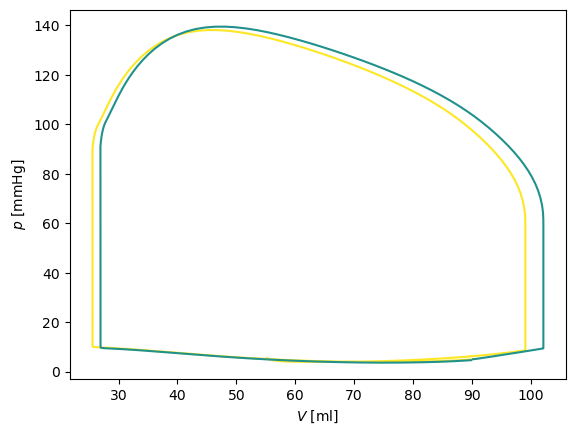

In [14]:
# LV PV loop
p0D.plot_PVloop('l', 'all', unit='mmHg')  # arguments are (side = 'rv' or 'lv', cycle = an integer or 'all', unit = 'mmHg' or 'kPa')

<Axes: xlabel='Time [s]', ylabel='$p$ [mmHg]'>

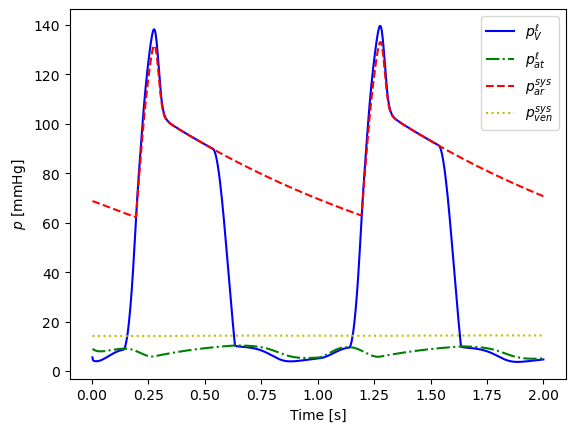

In [15]:
# Wiggers diagram
fig, axs = plt.subplots(1,1, clear=True, num=1)
p0D.plot_Wiggers('l', 'all', unit='mmHg', ax=axs)